In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
import cv2
import os
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.applications import VGG16

2024-09-06 11:39:54.309535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels
readDatasetObject = ReadDataset('train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()
images.shape, labels.shape

((5216, 64, 64, 1), (5216,))

In [4]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 1),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

2024-09-06 11:40:20.500679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2936 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [5]:
history = m.fit(images, labels,
                epochs = 60, batch_size = 32,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 4, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60


2024-09-06 11:40:23.730546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-06 11:40:24.352944: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6884029c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-06 11:40:24.353024: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-09-06 11:40:24.368238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-06 11:40:24.592165: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 [==============================] - 12s 36ms/step - loss: 0.5183 - val_loss: 0.6942
Epoch 2/60
131/131 [==============================] - 3s 25ms/step - loss: 0.2869 - val_loss: 0.6362
Epoch 3/60
131/131 [==============================] - 3s 24ms/step - loss: 0.2021 - val_loss: 0.5234
Epoch 4/60
131/131 [==============================] - 3s 25ms/step - loss: 0.1751 - val_loss: 0.3351
Epoch 5/60
131/131 [==============================] - 3s 24ms/step - loss: 0.1626 - val_loss: 0.1636
Epoch 6/60
131/131 [==============================] - 3s 24ms/step - loss: 0.1497 - val_loss: 0.2081
Epoch 7/60
131/131 [==============================] - 3s 25ms/step - loss: 0.1362 - val_loss: 0.1343
Epoch 8/60
131/131 [==============================] - 3s 24ms/step - loss: 0.1278 - val_loss: 0.4196
Epoch 9/60
131/131 [==============================] - 3s 24ms/step - loss: 0.1192 - val_loss: 0.1958
Epoch 10/60
131/131 [==============================] - 3s 24ms/step - loss: 0.1151 - val_loss: 0.0807

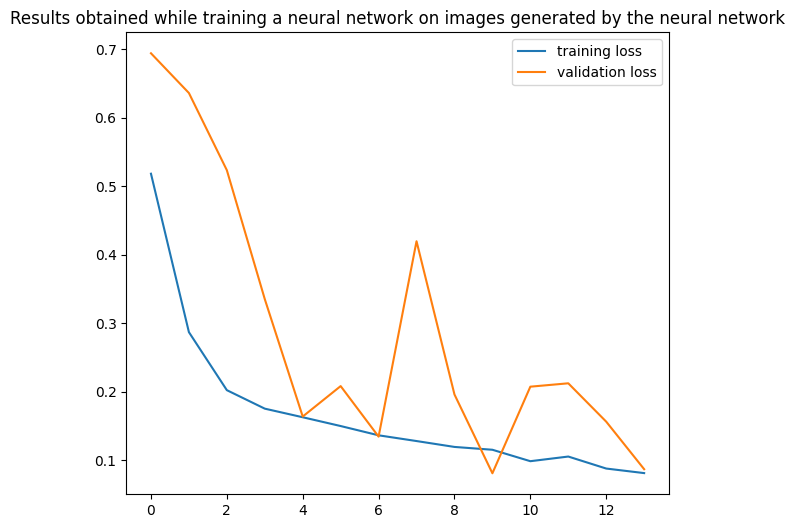

In [6]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [7]:
images.shape,labels.shape

((5216, 64, 64, 1), (5216,))

In [8]:
m.evaluate(images, labels)

163/163 [==============================] - 1s 8ms/step - loss: 0.1190


0.11904392391443253

In [9]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 1s 6ms/step


TensorShape([5216])

In [10]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [11]:
accuracy_score(y_pred, labels)*100

97.45015337423312

In [12]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1218
           1       1.00      0.97      0.98      3998

    accuracy                           0.97      5216
   macro avg       0.95      0.98      0.97      5216
weighted avg       0.98      0.97      0.97      5216



In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1213,    5],
       [ 128, 3870]])

In [14]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,1213,5
PNEUMONIA,128,3870


In [15]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 98.31068207798806, recall_score: 96.7983991995998, precision_score: 99.87096774193547


<Axes: >

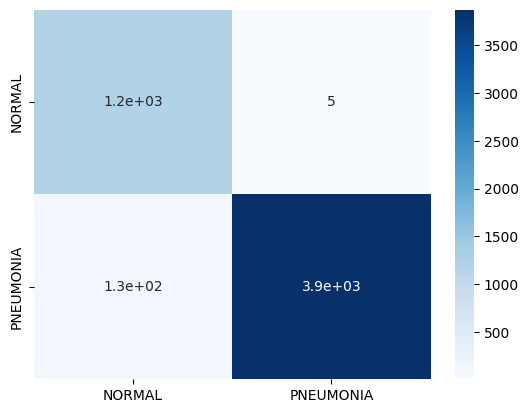

In [16]:
sns.heatmap(cmObject, annot = True, cmap="Blues")